# Sentiment Analysis of Restaurant Reviews using NLTK and TextBlob

<ins>Date Created/ Submitted: 25 Feb 19</ins>

For this capstone project, the aim is to predict the sentiment of a review using sentiment analysis. And, apply topic modelling using LDA or similar analysis to identify key topics/ area within each sentiment class (e.g. which topics/areas garner mostly negative reviews and which topic/areas garner mostly postive reviews).

This python implementation of this project is split into several python notebooks.
* Part 1: Web-scraping review data (The code for this is not uploaded to github)
* Part 2: Explore the data
* Part 3: Prepare the data (pre-processing)
* Part 4a: Modelling using word vector generated from CountVectorizer
* Part 4b: Modelling using word vector generated from TDIDFVectorizer
* Part 5: Summary Results with Topics Identified

### Part 5. Summary with Topics Identified

Note: Output of some cells have been cleared to desensitize the source of the web-scraping, and reduce the size of the python notebook.

### 1. Setting Up the Environment

In [ ]:
## import various nlp packages
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from nltk import FreqDist
import contractions
import unicodedata

import gensim
from gensim import corpora 

import spacy

from textblob import TextBlob

import csv
import random
import re
import string
import time
from pprint import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Set seed for replicability.
seedno = 18704
np.random.seed(seedno)

# to facilitate viewing full text
pd.set_option('display.max_colwidth', 120)
#pd.options.display.html.use_mathjax = False

In [ ]:
def plot_bars(attribute,setpalette='Spectral',setrotation=0,showlabels=True,sortvalue='ascending',sortcount=None):
    sns.set(style="whitegrid")
# Store frequency counts of each label where unique is the label and counts is its frequency
    unique, counts = np.unique(attribute.astype(str), return_counts=True)
    unique_counts = pd.DataFrame({'Value': unique, 'Count': counts})
    if sortvalue == 'descending':
        unique_counts = unique_counts.sort_values('Value', ascending=False)
    if sortvalue == 'ascending':
        unique_counts = unique_counts.sort_values('Value', ascending=True)
    if sortcount == 'descending':
        unique_counts = unique_counts.sort_values('Count', ascending=False)
    if sortcount == 'ascending':
        unique_counts = unique_counts.sort_values('Count', ascending=True)

# plot frequency counts
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.barplot(x="Value", y="Count", data=unique_counts,palette=setpalette)
    if showlabels==True:
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height),
            ha="center") 
    plt.setp(ax.get_xticklabels(), rotation=setrotation)
    plt.show()

### Restaurant Reviews
### Read in files (from directory) for analysis 

In [3]:
rreviews = pd.read_csv('rreviews.csv')
rreviews = rreviews.drop(['Unnamed: 0'], axis=1)

In [4]:
rreviews.shape

(451065, 22)

In [5]:
# change date columns from string to date type. even though data preparation
# was performed in restaurantPreparation.ipynb, because the results was 
# exported to csv, it is necessary to re-define date format
import datetime
date_format = '%Y/%m/%d'
rreviews['review_date'] = pd.to_datetime(rreviews['review_date'])
rreviews['experience_date'] = pd.to_datetime(rreviews['experience_date'])

In [ ]:
# display first two document text
display(rreviews.head(2))

### Text (Review) Preprocessing Steps 

In [7]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import pos_tag_sents

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alphaniang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alphaniang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
#replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
lemma = WordNetLemmatizer()
stopwords_list = stopwords.words('english')

In [ ]:
#define a new function clean that returns cleaned doc.
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', \
                    'ignore').decode('utf-8', 'ignore')
    return text

def clean(doc):
    fix_accent=remove_accented_chars(doc)
    tagged_words=[]
    for sent in pos_tag_sents(map(word_tokenize, sent_tokenize(fix_accent))):
        tagged_words += sent
    normalized = ' '.join(lemma.lemmatize(str(word).lower(), \
                    get_wordnet_pos(pos)) for word, pos in tagged_words) 
    fix_contractions=contractions.fix(normalized)
    fix_repeats=re.sub(r'(.)\1{2,}', r'\1\1', fix_contractions)
    keep_alpha=re.sub('[^a-z]+', ' ', fix_repeats)
    min_len_three = ' '.join([i for i in keep_alpha.split() \
                    if (len(i)>2 and i!='no')])
    stop_free = ' '.join([i for i in min_len_three.split() \
                    if i not in stopwords_list])
    return stop_free

### Classifying Review Sentiment

### Sentiment Polarity

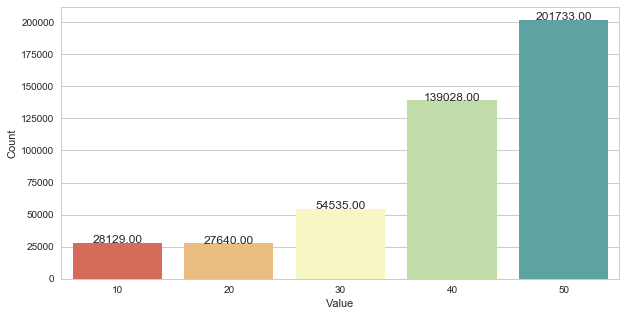

In [10]:
plot_bars(rreviews['rating'])

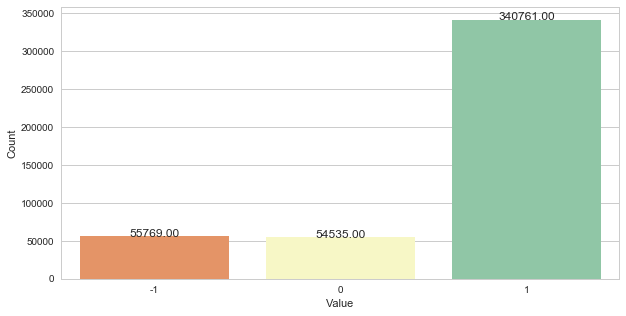

In [11]:
plot_bars(rreviews['rating_polarity'])

In [12]:
rreviews_polarity = rreviews[rreviews.rating_polarity != 0]

In [14]:
len(rreviews_polarity)

396530

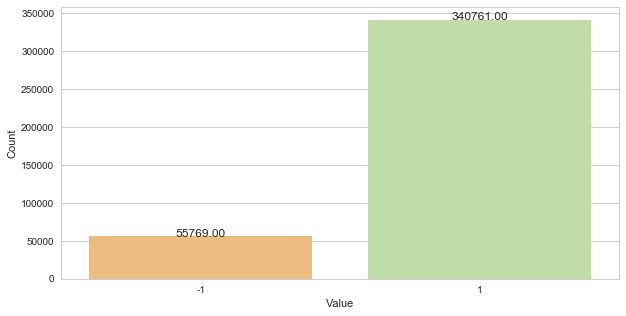

In [13]:
plot_bars(rreviews_polarity['rating_polarity'])

## Using Text Blob

In [ ]:
polarity_scores=[]
subjectivity_scores=[]
for doc in rreviews_polarity['review_text']:
    blob=TextBlob(doc)
    polarity_scores.append(blob.sentiment.polarity)
    subjectivity_scores.append(blob.sentiment.subjectivity)

In [ ]:
rreviews_polarity['blob_polaritysc']=polarity_scores
rreviews_polarity['blob_subjectivitysc']=subjectivity_scores

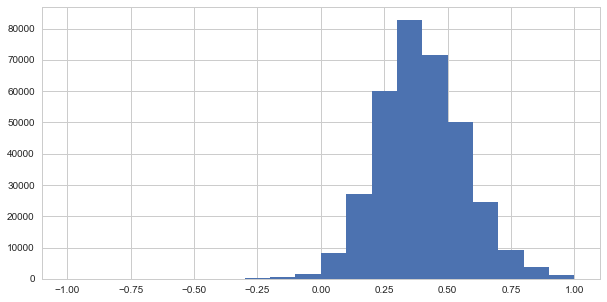

In [176]:
rreviews_polarity[rreviews_polarity['rating_polarity']==1]['blob_polaritysc'].hist(bins=20,figsize=(10,5))

In [179]:
rreviews_polarity[rreviews_polarity['rating_polarity']==1]['blob_polaritysc'].describe()

count    340761.000000
mean          0.397812
std           0.169494
min          -1.000000
25%           0.283611
50%           0.389560
75%           0.503333
max           1.000000
Name: blob_polaritysc, dtype: float64

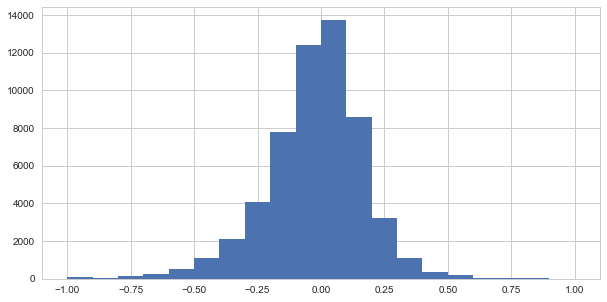

In [177]:
rreviews_polarity[rreviews_polarity['rating_polarity']==-1]['blob_polaritysc'].hist(bins=20,figsize=(10,5))

In [180]:
rreviews_polarity[rreviews_polarity['rating_polarity']==-1]['blob_polaritysc'].describe()

count    55769.000000
mean        -0.021233
std          0.192571
min         -1.000000
25%         -0.121648
50%         -0.004333
75%          0.097443
max          1.000000
Name: blob_polaritysc, dtype: float64

## Train Test Split

In [ ]:
# separate the features from the label. For X - drop labels, unnecessary attributes. 
# remaining attributes are review_date, word_count, char_count, avg_word_len,
# stop_perword, punc_perchar, alpha_perchar, numeric_count, upper_perchar, user_islocal
rreviews_X = rreviews_polarity.drop(['type','id','review_id','rating','review_date',\
                                     'experience_date','contributions','helpful_vote',\
                                     'user_id','user_name'], axis=1) 
rreviews_y = rreviews_polarity['rating_polarity'].copy()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rreviews_X, rreviews_y,\
                                train_size=0.80, test_size=0.20, random_state=seedno)

In [ ]:
#Check total count match
display(len(X_train))
display(len(X_test))
display(len(X_train)+len(X_test))

## Create the Word Matrix

### Count Vectorizer

In [ ]:
# we use the count vectorizer function (w the clean function as defined prior) 
from sklearn.feature_extraction.text import CountVectorizer
xtrain_cvec = CountVectorizer(preprocessor=clean,min_df=0.0001)

In [ ]:
# we fit a word matrix based on the review text
xtrain_cvec.fit(X_train['review_text'])

In [ ]:
# we create a word matrix based on the review text
xtrain_cvec_matrix = xtrain_cvec.transform(X_train['review_text'])

In [ ]:
print(xtrain_cvec.get_feature_names())

In [ ]:
len(xtrain_cvec.get_feature_names())

In [ ]:
xtest_cvec_matrix = xtrain_cvec.transform(X_test['review_text'])

### TF-IDF Vectorizer

In [ ]:
# we also try the tfidf vectorizer function (w the clean function as defined prior) 
from sklearn.feature_extraction.text import TfidfVectorizer
xtrain_tvec = TfidfVectorizer(preprocessor=clean,min_df=0.0001)

In [ ]:
# we fit a word matrix based on the review text
xtrain_tvec.fit(X_train['review_text'])

In [ ]:
# we create a word matrix based on the review text
xtrain_tvec_matrix = xtrain_tvec.transform(X_train['review_text'])

In [ ]:
print(xtrain_tvec.get_feature_names())

In [ ]:
len(xtrain_tvec.get_feature_names())

In [ ]:
xtest_tvec_matrix = xtrain_tvec.transform(X_test['review_text'])

## Word Frequency to Word Cloud

In [30]:
xtrain_cvec_sumwords=xtrain_cvec_matrix.sum(axis=0)

In [31]:
xtrain_cvec_wordfreq = [(word, xtrain_cvec_sumwords[0, idx]) for word, idx in xtrain_cvec.vocabulary_.items()]
xtrain_cvec_wordfreq =sorted(xtrain_cvec_wordfreq, key = lambda x: x[1], reverse=True)

In [33]:
xtrain_cvec_wordfreq[0:10]

[('food', 306008),
 ('great', 222633),
 ('good', 192716),
 ('service', 178448),
 ('restaurant', 132237),
 ('place', 108287),
 ('staff', 107130),
 ('would', 87516),
 ('time', 85285),
 ('meal', 84833)]

In [35]:
xtrain_cvec_wordfreq[-10:]

[('updating', 32),
 ('venues', 32),
 ('produced', 32),
 ('scare', 32),
 ('selfish', 32),
 ('gardens', 32),
 ('file', 32),
 ('gag', 32),
 ('unfold', 32),
 ('oustanding', 32)]

In [37]:
d={}
for w, count in xtrain_cvec_wordfreq:
    d[w] = count

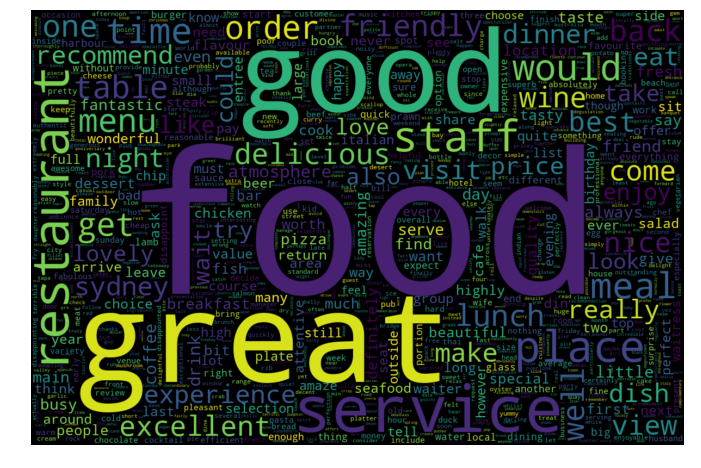

In [38]:
from wordcloud import WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.misc import imread
from palettable.colorbrewer.diverging import Spectral_9
from matplotlib.colors import makeMappingArray

#Generating wordcloud. Relative scaling value is to adjust the importance of a frequency word.
#See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py
wordcloud = WordCloud(width=1200,height=800, max_words=1000,relative_scaling=0.8,normalize_plurals=False).generate_from_frequencies(d)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.show()

## Model Selection

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

## Logistic Regression

In [ ]:
lr_starttime=time.time()
lr = LogisticRegression()
lr.fit(xtrain_cvec_matrix, y_train)
y_pred_lr=lr.predict(xtest_cvec_matrix)
lr_runtime=time.time()-lr_starttime

In [42]:
display(accuracy_score(y_test, y_pred_lr))
display(precision_score(y_test, y_pred_lr))
display(recall_score(y_test, y_pred_lr))
display(f1_score(y_test, y_pred_lr))
display(roc_auc_score(y_test, y_pred_lr))
display(lr_runtime)

0.9772400574988022

0.9838853419434015

0.9896834494312671

0.9867758786164857

0.945863039102845

21.736878871917725

In [43]:
lrt_starttime=time.time()
lrt = LogisticRegression()
lrt.fit(xtrain_tvec_matrix, y_train)
y_pred_lrt=lrt.predict(xtest_tvec_matrix)
lrt_runtime=time.time()-lrt_starttime

/Users/alphaniang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [44]:
display(accuracy_score(y_test, y_pred_lrt))
display(precision_score(y_test, y_pred_lrt))
display(recall_score(y_test, y_pred_lrt))
display(f1_score(y_test, y_pred_lrt))
display(roc_auc_score(y_test, y_pred_lrt))
display(lrt_runtime)

0.97812271454871

0.9831261748291489

0.9915204420539047

0.9873054663320481

0.9443392618795278

3.831063985824585

##  Word List

In [46]:
len(xtrain_cvec.get_feature_names())

9689

In [47]:
lr_feature_to_coef = {
    word: coef for word, coef in zip(
        xtrain_cvec.get_feature_names(), lr.coef_[0]
    )
}

In [49]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

          -1       0.94      0.90      0.92     11260
           1       0.98      0.99      0.99     68046

   micro avg       0.98      0.98      0.98     79306
   macro avg       0.96      0.95      0.95     79306
weighted avg       0.98      0.98      0.98     79306



In [50]:
for best_positive in sorted(
    lr_feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:30]:
    print (best_positive)

('perfection', 2.5528815265068023)
('enviable', 2.287669668328051)
('pleasantly', 2.237370527705455)
('divine', 2.2247118709363787)
('juicy', 2.218030630984672)
('delicious', 2.2135630703875653)
('exquisite', 2.1971591422413623)
('delish', 2.191422372091089)
('alternatively', 2.180562505672284)
('continental', 2.1068753443062387)
('yummy', 2.0996653129316307)
('incredible', 2.0922325661123296)
('excellent', 2.078468899679042)
('adventurous', 2.057105557137174)
('brilliantly', 2.0328362602399053)
('truely', 1.9951083146980932)
('accommodating', 1.968577898614699)
('enormous', 1.9650815551426806)
('wonderfully', 1.9423247757066229)
('flawless', 1.9381962500570915)
('wifes', 1.9337663463492674)
('exceed', 1.9334291140403086)
('sensational', 1.9065554617762706)
('die', 1.892070026878741)
('dipping', 1.8805783394396514)
('standouts', 1.8608242183892372)
('downside', 1.8142017716034022)
('fritto', 1.812713208990054)
('misto', 1.812702703081282)
('worthwhile', 1.8039713405079294)


In [51]:
for best_negative in sorted(
    lr_feature_to_coef.items(), 
    key=lambda x: x[1])[:30]:
    print (best_negative)

('worst', -3.422098931656599)
('underwhelming', -2.7942604470547723)
('terrible', -2.775426308692551)
('downhill', -2.7075035216606778)
('poisoning', -2.6777812193193644)
('mediocre', -2.67547714177895)
('appal', -2.649183859369672)
('disappointing', -2.631184848998377)
('unimpressed', -2.4858375030478226)
('overrate', -2.4042519798987367)
('awful', -2.3849652636609107)
('dissapointing', -2.345819648368107)
('poor', -2.344993421835437)
('tasteless', -2.330008870218336)
('disapointed', -2.3288201400972453)
('eatable', -2.2946567857992775)
('substandard', -2.2754882813434083)
('pathetic', -2.260742435579766)
('horrendous', -2.232626055243365)
('horrible', -2.225466335680571)
('meh', -2.223429298931113)
('passable', -2.1638625340073783)
('ordinary', -2.150359054395782)
('inedible', -2.148415482112052)
('unacceptable', -2.117581149925716)
('bland', -2.0866291061985636)
('rudest', -2.084649035849489)
('rip', -2.0791720460468612)
('lousy', -2.0767250013223584)
('dissapointed', -2.07479807456

In [ ]:
lr_itemcoef=sorted(lr_feature_to_coef.items(), key=lambda x: x[1], reverse=True)

In [ ]:
lr_pos_itemcoef=[(w, coef) for w, coef in lr_itemcoef if coef>0]

In [ ]:
lr_pos_itemcoef

In [ ]:
d={}
for w, coef in lr_pos_itemcoef:
    d[w] = coef

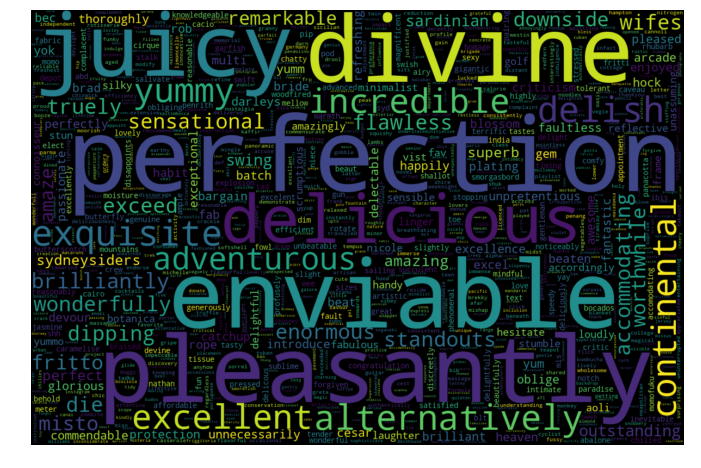

In [57]:
from wordcloud import WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.misc import imread
from palettable.colorbrewer.diverging import Spectral_9
from matplotlib.colors import makeMappingArray

#Generating wordcloud. Relative scaling value is to adjust the importance of a frequency word.
#See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py
wordcloud = WordCloud(width=1200,height=800, max_words=1000,relative_scaling=0.8,normalize_plurals=False).generate_from_frequencies(d)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.show()

In [ ]:
lr_itemcoef=sorted(lr_feature_to_coef.items(), key=lambda x: x[1], reverse=False)

In [ ]:
lr_neg_itemcoef=[(w, coef) for w, coef in lr_itemcoef if coef<0]

In [ ]:
lr_neg_itemcoef

In [ ]:
d={}
for w, coef in lr_neg_itemcoef:
    d[w] = coef*-1

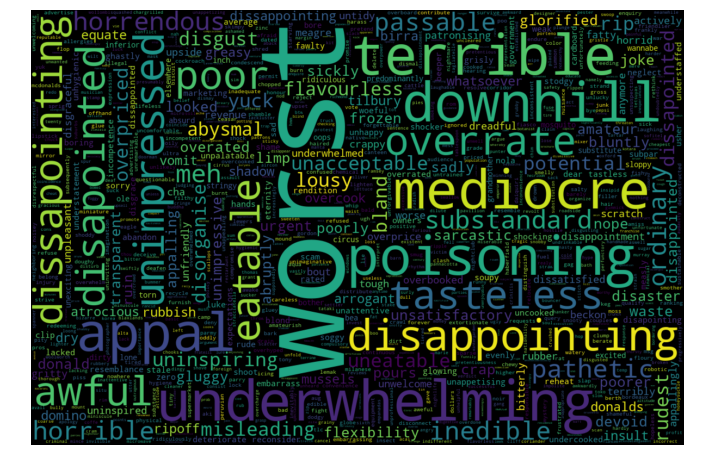

In [62]:
from wordcloud import WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.misc import imread
from palettable.colorbrewer.diverging import Spectral_9
from matplotlib.colors import makeMappingArray

#Generating wordcloud. Relative scaling value is to adjust the importance of a frequency word.
#See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py
wordcloud = WordCloud(width=1200,height=800, max_words=1000,relative_scaling=0.8,normalize_plurals=False).generate_from_frequencies(d)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.show()

## Identifying Review Aspects

## Topic Modelling

In [ ]:
#Update stop word list to include words with document frequency less than 0.0001 for topic modelling to downsize the wordlist
stopdf_list = set(stopwords.words('english')) 
stopdf_list.update(list(xtrain_cvec.stop_words_))

In [ ]:
#Define a new clean function with updated stop word list
def clean_updstop(doc):
    fix_accent=remove_accented_chars(doc)
    tagged_words=[]
    for sent in pos_tag_sents(map(word_tokenize, sent_tokenize(fix_accent))):
        tagged_words += sent
    normalized = ' '.join(lemma.lemmatize(str(word).lower(), \
                    get_wordnet_pos(pos)) for word, pos in tagged_words) 
    fix_contractions=contractions.fix(normalized)
    fix_repeats=re.sub(r'(.)\1{2,}', r'\1\1', fix_contractions)
    keep_alpha=re.sub('[^a-z]+', ' ', fix_repeats)
    min_len_three = ' '.join([i for i in keep_alpha.split() \
                    if (len(i)>2 and i!='no')])
    stop_free = ' '.join([i for i in min_len_three.split() \
                    if i not in stopdf_list])
    return stop_free

## Topic Modelling for Positive Class

### Create Bag of Words

In [ ]:
X_train_pclean = [clean(doc).split() for doc in X_train[X_train['rating_polarity']==1]['review_text']]

In [ ]:
# corpora.Dictionary creates a dictionary of mapping between words and its id
dictionary_pos = corpora.Dictionary(X_train_pclean)
doc_term_matrix_pos = [dictionary_pos.doc2bow(doc) for doc in X_train_pclean]

In [ ]:
list(dictionary_pos.token2id)

In [ ]:
len(dictionary_pos.token2id)

### Create LDA Model ###

In [96]:
topic_num = 5 
word_num = 5
Lda = gensim.models.ldamodel.LdaModel
ldamodel_pos = Lda(doc_term_matrix_pos, num_topics = topic_num, id2word = dictionary_pos,
passes=20, random_state=seedno)
pprint(ldamodel_pos.print_topics(num_topics=topic_num, num_words=word_num))

[(0,
  '0.012*"delicious" + 0.011*"salad" + 0.010*"order" + 0.010*"dish" + '
  '0.009*"pork"'),
 (1,
  '0.027*"food" + 0.023*"good" + 0.018*"place" + 0.015*"great" + '
  '0.015*"breakfast"'),
 (2,
  '0.025*"view" + 0.018*"good" + 0.018*"great" + 0.013*"lunch" + '
  '0.012*"place"'),
 (3,
  '0.019*"restaurant" + 0.015*"food" + 0.012*"wine" + 0.011*"experience" + '
  '0.011*"service"'),
 (4,
  '0.062*"food" + 0.061*"great" + 0.039*"service" + 0.034*"good" + '
  '0.022*"staff"')]


In [97]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis_lda=pyLDAvis.gensim.prepare(ldamodel_pos,doc_term_matrix_pos,dictionary_pos)
vis_lda

/Users/alphaniang/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.027289 -0.132407       1        1  27.717600
4      0.093801 -0.108485       2        1  22.791571
1      0.060413 -0.031354       3        1  19.745823
2      0.137330  0.224667       4        1  15.238539
0     -0.318832  0.047580       5        1  14.506467, topic_info=     Category           Freq        Term          Total  loglift  logprob
term                                                                     
72    Default  209412.000000       great  209412.000000  30.0000  30.0000
90    Default  256070.000000        food  256070.000000  29.0000  29.0000
62    Default  145360.000000     service  145360.000000  28.0000  28.0000
199   Default   52808.000000        view   52808.000000  27.0000  27.0000
55    Default  169832.000000        good  169832.000000  26.0000  26.0000
50    Default   30827.000000   breakfast   30827.000000  25.0000  25.0000
63    Default   85660.000000       staff   85660.000000  24.0000  24.0000
230   Default   63348.000000    friendly   63348.000000  23.0000  23.0000
75    Default   89481.000000       place   89481.000000  22.0000  22.0000
312   Default   32123.000000      coffee   32123.000000  21.0000  21.0000
201   Default   38741.000000  atmosphere   38741.000000  20.0000  20.0000
172   Default   60075.000000       lunch   60075.000000  19.0000  19.0000
48    Default   23208.000000         bar   23208.000000  18.0000  18.0000
130   Default   40464.000000  experience   40464.000000  17.0000  17.0000
184   Default   55082.000000        wine   55082.000000  16.0000  16.0000
99    Default  108274.000000  restaurant  108274.000000  15.0000  15.0000
138   Default   27021.000000    location   27021.000000  14.0000  14.0000
919   Default   17842.000000       salad   17842.000000  13.0000  13.0000
84    Default   47824.000000      dinner   47824.000000  12.0000  12.0000
7     Default   60942.000000   delicious   60942.000000  11.0000  11.0000
56    Default   14849.000000     harbour   14849.000000  10.0000  10.0000
21    Default   48008.000000       night   48008.000000   9.0000   9.0000
493   Default   14178.000000        pork   14178.000000   8.0000   8.0000
656   Default   25374.000000       pizza   25374.000000   7.0000   7.0000
200   Default   35026.000000      always   35026.000000   6.0000   6.0000
719   Default   13511.000000        lamb   13511.000000   5.0000   5.0000
254   Default   17441.000000        beer   17441.000000   4.0000   4.0000
244   Default   49842.000000       table   49842.000000   3.0000   3.0000
177   Default   47494.000000   recommend   47494.000000   2.0000   2.0000
206   Default   19832.000000        fish   19832.000000   1.0000   1.0000
...       ...            ...         ...            ...      ...      ...
1412   Topic5    3670.295410      tomato    3671.095947   1.9304  -6.0377
2890   Topic5    3442.610352      pepper    3443.411377   1.9303  -6.1017
713    Topic5    3435.692383      fillet    3436.494873   1.9303  -6.1037
663    Topic5    3897.699219        soft    3898.631592   1.9303  -5.9776
1837   Topic5    3150.281494       squid    3151.083252   1.9303  -6.1905
344    Topic5    3146.624268   vegetable    3147.430176   1.9303  -6.1916
919    Topic5   16293.401367       salad   17842.714844   1.8397  -4.5472
441    Topic5    7592.745605        duck    8846.126953   1.7778  -5.3108
213    Topic5   12550.532227       steak   17517.849609   1.5971  -4.8082
6      Topic5   12550.004883     chicken   17858.132812   1.5778  -4.8082
337    Topic5   13635.728516        cook   20500.886719   1.5228  -4.7253
71     Topic5    6059.617188         fry    7124.560059   1.7687  -5.5363
168    Topic5   10174.719727      entree   15357.730469   1.5189  -5.0180
926    Topic5    5855.292969       sweet    6989.892090   1.7535  -5.5706
166    Topic5   13519.202148     dessert   24608.316406   1.3316  -4.7338
206    Topic5   11622.23339

## Topic Modelling for Negative Class

### Create Bag of Words

In [ ]:
Xtrain_nclean = [clean(doc).split() for doc in X_train[X_train['rating_polarity']==-1]['review_text']]

In [ ]:
# corpora.Dictionary creates a dictionary of mapping between words and its id
dictionary_neg = corpora.Dictionary(Xtrain_nclean)
doc_term_matrix_neg = [dictionary_neg.doc2bow(doc) for doc in Xtrain_nclean]

In [ ]:
list(dictionary_neg.token2id)

In [ ]:
len(dictionary_neg.token2id)

### Create LDA Model ###

In [ ]:
topic_num = 5 
word_num = 5
Lda = gensim.models.ldamodel.LdaModel
ldamodel_neg = Lda(doc_term_matrix_neg, num_topics = topic_num, id2word = dictionary_neg,
passes=20, random_state=seedno)
pprint(ldamodel_neg.print_topics(num_topics=topic_num, num_words=word_num))

In [104]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis_lda=pyLDAvis.gensim.prepare(ldamodel_neg,doc_term_matrix_neg,dictionary_neg)
vis_lda

/Users/alphaniang/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.140133  0.141203       1        1  39.234524
4     -0.113773 -0.012600       2        1  20.683907
3     -0.111026 -0.158863       3        1  17.125187
0      0.098030  0.043586       4        1  16.333883
1      0.266902 -0.013327       5        1   6.622496, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
64    Default   6661.000000        fish   6661.000000  30.0000  30.0000
76    Default  29666.000000       order  29666.000000  29.0000  29.0000
25    Default  46707.000000        food  46707.000000  28.0000  28.0000
53    Default  16402.000000        wait  16402.000000  27.0000  27.0000
351   Default   5788.000000        chip   5788.000000  26.0000  26.0000
409   Default   7073.000000        wine   7073.000000  25.0000  25.0000
297   Default   8745.000000        dish   8745.000000  24.0000  24.0000
85    Default  22759.000000  restaurant  22759.000000  23.0000  23.0000
46    Default  22217.000000       table  22217.000000  22.0000  22.0000
44    Default  29163.000000     service  29163.000000  21.0000  21.0000
268   Default  15978.000000         ask  15978.000000  20.0000  20.0000
89    Default   5209.000000       steak   5209.000000  19.0000  19.0000
283   Default   9869.000000      minute   9869.000000  18.0000  18.0000
947   Default   3295.000000       prawn   3295.000000  17.0000  17.0000
125   Default   5798.000000       pizza   5798.000000  16.0000  16.0000
219   Default  16890.000000       place  16890.000000  15.0000  15.0000
86    Default   3209.000000     seafood   3209.000000  14.0000  14.0000
127   Default   5398.000000       salad   5398.000000  13.0000  13.0000
207   Default   7304.000000       taste   7304.000000  12.0000  12.0000
329   Default  10972.000000        tell  10972.000000  11.0000  11.0000
2     Default  22664.000000        good  22664.000000  10.0000  10.0000
103   Default   4935.000000     chicken   4935.000000   9.0000   9.0000
391   Default   4436.000000       sauce   4436.000000   8.0000   8.0000
83    Default   9917.000000       price   9917.000000   7.0000   7.0000
376   Default  17838.000000        meal  17838.000000   6.0000   6.0000
744   Default   7634.000000        main   7634.000000   5.0000   5.0000
58    Default   5391.000000        cook   5391.000000   4.0000   4.0000
400   Default  18932.000000       staff  18932.000000   3.0000   3.0000
379   Default  11296.000000        menu  11296.000000   2.0000   2.0000
180   Default  13260.000000        like  13260.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
2238   Topic5    216.111191        stir    216.911896   2.7110  -6.6979
4583   Topic5    211.756943    linguine    212.563980   2.7109  -6.7182
2255   Topic5    199.855453     trolley    200.655640   2.7107  -6.7761
1386   Topic5    157.417313       chili    158.219498   2.7096  -7.0148
3452   Topic5    155.482544  vietnamese    156.280014   2.7096  -7.0271
3357   Topic5    154.801132      mornay    155.596970   2.7096  -7.0315
1017   Topic5   1014.801392      oyster   1102.854370   2.6315  -5.1512
892    Topic5   1036.599487    calamari   1152.429565   2.6088  -5.1300
2004   Topic5    820.957458        soup    978.827576   2.5388  -5.3632
515    Topic5   1039.004272        salt   1301.404297   2.4895  -5.1277
995    Topic5    563.475159        deep    660.380859   2.5560  -5.7396
351    Topic5   3601.602295        chip   5788.791016   2.2402  -3.8845
2064   Topic5    701.948914      chilli    875.275269   2.4940  -5.5198
506    Topic5    600.096497      pepper    758.129639   2.4809  -5.6766
579    Topic5   1507.229126       fresh   2640.333496   2.1541  -4.7556
876    Topic5    890.710876        duck   1378.622437   2.2779  -5.2817
999    Topic5   1076.190796         fry   2010.4438